# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
 * [Obtain Coordinates, Boundaries, Population Density of London Boroughs](#boroughs)
 * [Generate Neighborhoods](#generate)
 * [Venues](#venues) 
 * [Neighborhoods Clustering](#clustering)
 * ['Candidate' Neighborhoods](#candidates)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

John with his family lives in London. He really likes his house and the neighborhood. However kids are growing and the current house seems too small for them so John is thinking of buying a bigger house. 

Unfortunately there are not that many offers on the real estate market in his neighborhood. John has been checking adverts for several months but couldn't find anything suitable. So John decided to have a look at the houses available in the other areas of London.  

This project will help John to narrow down his search and offer him the list of 'candidate' neighborhoods that would be very similar to the current 'reference' neighborhood in terms of the number and categories of venues around and teh population density.

## Methodology <a name="introduction"></a>

For this project we'll generate a regularly spaced grid of locations covering the whole territory of London to define 'candidate' neighborhoods, then obtain information on the venues in each area using Foursquare API and use K-means clustering algorithm to find all neighborhoods similar to the 'reference' one.

## Data <a name="introduction"></a>

Following data sources will be needed to complete the project:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Nominatim library of the geopy package**
* number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinates of the centers and the boundaries of London boroughs will be downloaded from **[the Open Geography Portal](http://geoportal.statistics.gov.uk) by the Office for National Statistics**, the UK’s largest independent producer of official statistics and its recognised national statistical institute.

## Analysis <a name="introduction"></a>

<div class="alert alert-block alert-info">Let's import all packages and libraries required in this notebook</div>

In [1]:
import time
import math
import numpy as np 
import pandas as pd
import json 
from pandas.io.json import json_normalize
import requests

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import folium
from folium import plugins

from sklearn.cluster import KMeans
 
import shapely.geometry
import pyproj
from geopy.geocoders import Nominatim

import csv
import os.path

### Obtain Coordinates, Boundaries, Population Density of London Boroughs <a name="boroughs"></a>

<div class="alert alert-block alert-info">Let's download the geographic coordinates of the centers of UK local authorities districts from the Open Geography Portal by the Office for National Statistics, the UK’s largest independent producer of official statistics and its recognised national statistical institute.  
We'll use the CSV file available here: <a href="https://geoportal.statistics.gov.uk/datasets/local-authority-districts-april-2019-boundaries-uk-buc">Local Authority Districts (April 2019) Boundaries UK BUC</a></div>

In [2]:
local_areas_df = pd.read_csv('Local_Authority_Districts_April_2019_Boundaries_UK_BUC.csv')
local_areas_df.drop(columns=['FID', 'LAD19NMW', 'BNG_E', 'BNG_N', 'Shape__Area', 'Shape__Length'], inplace=True)
local_areas_df.rename(columns={'LAD19CD':'LAD_CD', 'LAD19NM':'LAD_NM'}, inplace=True)
local_areas_df.head()

LAD_CD                LAD_NM     LONG      LAT
0  E06000001            Hartlepool -1.27023  54.6762
1  E06000002         Middlesbrough -1.21099  54.5447
2  E06000003  Redcar and Cleveland -1.00611  54.5675
3  E06000004      Stockton-on-Tees -1.30669  54.5569
4  E06000005            Darlington -1.56835  54.5353

<div class="alert alert-block alert-info">Now we need to obtain the information on the standard area measurements for the UK local authorities districts to get the square of each district.
As for teh previous data set we'll get the information from the Open Geography Portal: <a href="https://geoportal.statistics.gov.uk/datasets/standard-area-measurements-2018-for-eurostat-nuts-areas-in-the-united-kingdom">Standard Area Measurements (2018) for Eurostat NUTS Areas in the United Kingdom.
</a>  
The main attribute of this data set is AREALHECT (an area to mean high water excluding area of inland water (land area))</div>

In [3]:
sam = pd.read_csv('SAM_LAD_DEC_2018_UK.csv')
sam.drop(columns=['LAD18NM', 'AREAEHECT', 'AREACHECT', 'AREAIHECT', 'Unnamed: 6', 'Unnamed: 7'], inplace=True)
sam.rename(columns={'LAD18CD':'LAD_CD'}, inplace=True)
sam.head()

LAD_CD  AREALHECT
0  E06000001    9355.95
1  E06000002    5388.88
2  E06000003   24482.02
3  E06000004   20496.24
4  E06000005   19747.58

<div class="alert alert-block alert-info">We'll merge the dataframe that represents local authority districts and their coordinates with the information on the size of each area.</div>

In [4]:
areas = pd.merge(local_areas_df, sam, on='LAD_CD', how='left')
areas.head()

LAD_CD                LAD_NM     LONG      LAT  AREALHECT
0  E06000001            Hartlepool -1.27023  54.6762    9355.95
1  E06000002         Middlesbrough -1.21099  54.5447    5388.88
2  E06000003  Redcar and Cleveland -1.00611  54.5675   24482.02
3  E06000004      Stockton-on-Tees -1.30669  54.5569   20496.24
4  E06000005            Darlington -1.56835  54.5353   19747.58

<div class="alert alert-block alert-info">Now let's load the information on the UK population which is available on the website of the Office for National Statistics.  
The file <a href="https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fpopulationestimatesforukenglandandwalesscotlandandnorthernireland%2fmid20182019laboundaries/ukmidyearestimates20182018ladcodes.xls">Mid-2018: 2018 LA boundaries</a> can be found here: <a href="https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland">Estimates of the population for the UK, England and Wales, Scotland and Northern Ireland</a> 
</div>

In [5]:
df_population = pd.read_excel('ukmidyearestimates20182019ladcodes.xls', sheet_name='MYE2-All')
df_population.columns = df_population.iloc[3]
df_population.drop(df_population.index[3], inplace=True)
df_population.dropna(how='any', inplace=True)
df_population.rename(columns={'Code': 'LAD_CD'}, inplace=True)
df_population = df_population[['LAD_CD', 'Name', 'Geography1', 'All ages']]
df_population.columns = ['LAD_CD', 'LAD Name', 'LAD_TYPE', 'All ages']

df_population.head()

LAD_CD           LAD Name LAD_TYPE  All ages
4  K02000001     UNITED KINGDOM  Country  66435550
5  K03000001      GREAT BRITAIN  Country  64553909
6  K04000001  ENGLAND AND WALES  Country  59115809
7  E92000001            ENGLAND  Country  55977178
8  E12000001         NORTH EAST   Region   2657909

<div class="alert alert-block alert-info">Next few lines of teh code are used to find out the population density and add this information to the UK areas dataframe (areas)</div>

In [6]:
df_areas_population = pd.merge(local_areas_df, df_population, on='LAD_CD', how='left')
df_areas_population_rltv = pd.merge(df_areas_population, sam, on='LAD_CD', how='left')
df_areas_population_rltv.fillna(df_areas_population_rltv['AREALHECT'].mean(), inplace=True)
df_areas_population_rltv['Density'] = df_areas_population_rltv['All ages']/df_areas_population_rltv['AREALHECT']
df_areas_population_rltv.sort_values(by=['All ages'], ascending=False, inplace=True)
df_areas_population_rltv.drop(columns=['LAD Name'], inplace=True)
df_areas_population_rltv.head(5)

LAD_CD        LAD_NM     LONG      LAT               LAD_TYPE  \
271  E08000025    Birmingham -1.88141  52.4840  Metropolitan District   
281  E08000035         Leeds -1.50736  53.8227  Metropolitan District   
358  S12000049  Glasgow City -4.00000  60.0000           Council Area   
266  E08000019     Sheffield -1.54254  53.4036  Metropolitan District   
48   E06000052      Cornwall -4.64249  50.4502      Unitary Authority   

     All ages      AREALHECT    Density  
271   1141374   26779.120000  42.621789  
281    789194   55170.670000  14.304593  
358    626410   62924.698427   9.954915  
266    582506   36793.020000  15.831970  
48     565968  354599.420000   1.596077

<div class="alert alert-block alert-info">Our further analysis will be focused on London boroughs so let's create a new data frame that will hold information on London boroughs only</div>

In [7]:
df_areas_population_rltv_lon = df_areas_population_rltv[df_areas_population_rltv['LAD_TYPE'] == 'London Borough']
print(df_areas_population_rltv_lon.shape)
df_areas_population_rltv_lon.head()

(33, 8)


LAD_CD   LAD_NM      LONG      LAT        LAD_TYPE  All ages  \
286  E09000003   Barnet -0.218210  51.6111  London Borough    392140   
291  E09000008  Croydon -0.077610  51.3660  London Borough    385346   
308  E09000025   Newham  0.027369  51.5313  London Borough    352005   
292  E09000009   Ealing -0.314070  51.5244  London Borough    341982   
293  E09000010  Enfield -0.081470  51.6489  London Borough    333869   

     AREALHECT    Density  
286    8674.83  45.204344  
291    8649.43  44.551606  
308    3620.17  97.234384  
292    5554.47  61.568791  
293    8083.10  41.304574

<div class="alert alert-block alert-info">As it's seen from the below diagram the most populated boroughs are Islington and Tower Hamlets.  
The least populated boroughs are Havering and Bromley</div>

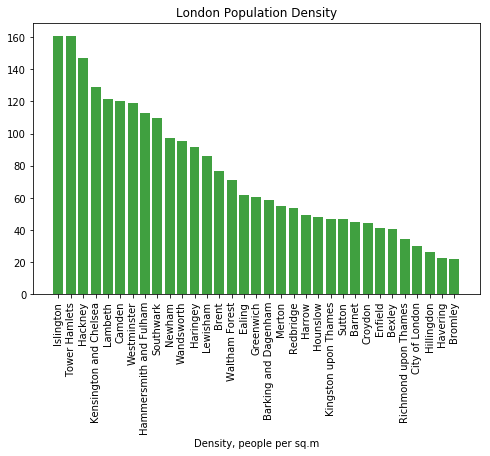

In [83]:
df_areas_population_rltv_lon_sorted = df_areas_population_rltv_lon_sorted.sort_values(by='Density', ascending=False)
plt.figure(figsize=(8,5))
plt.bar(df_areas_population_rltv_lon_sorted['LAD_NM'], df_areas_population_rltv_lon_sorted['Density'], color='g', alpha=0.75)
plt.title('London Population Density')
plt.xticks(df_areas_population_rltv_lon_sorted['LAD_NM'], rotation='vertical')
plt.xlabel('London Boroughs')
plt.xlabel('Density, people per sq.m')
plt.show()

<div class="alert alert-block alert-info">Let's also have a look at the London population density histogram</div>

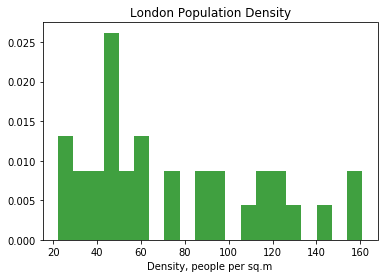

In [9]:
plt.hist(df_areas_population_rltv_lon['Density'], 20, density=1, facecolor='g', alpha=0.75)
plt.title('London Population Density')
plt.xlabel('Density, people per sq.m')
plt.show()

<div class="alert alert-block alert-info">To create a choropleth map we'll use the populationn density information in the df_areas_population_rltv_lon dataframe and the geographic coordinates of the boundaries of the UK local authoritity districts published by the Office for National Statistics on the Open Geography Portal.  
We'll use the GEOJSON file available here: <a href="https://geoportal.statistics.gov.uk/datasets/local-authority-districts-april-2019-boundaries-uk-buc">Local Authority Districts (April 2019) Boundaries UK BUC</a>  </div>

In [10]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="UK_coords")
location = geolocator.geocode("London")
london_center = [location.longitude, location.latitude]
uk_geo = 'Local_Authority_Districts_April_2019_Boundaries_UK_BUC.geojson.json'

In [11]:
# Let's define thresholds for the coropleth map
threshold_scale = np.geomspace(df_areas_population_rltv_lon['Density'].min(),
                              df_areas_population_rltv_lon['Density'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# Create the choropleth map 
uk_map = folium.Map(location=[london_center[1], london_center[0]], zoom_start=10)
uk_map.choropleth(
    geo_data=uk_geo, data=df_areas_population_rltv_lon, columns=['LAD_CD', 'Density'], key_on='feature.properties.LAD19CD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, line_opacity=0.2, legend_name='UK',
    threshold_scale=threshold_scale,
    reset=True
)

# Add markers for the London boroughs to the map
incidents = plugins.MarkerCluster().add_to(uk_map)

for lat, lng, LADcode, LADname in zip(df_areas_population_rltv_lon['LAT'], df_areas_population_rltv_lon['LONG'], 
                                  df_areas_population_rltv_lon['LAD_CD'], df_areas_population_rltv_lon['LAD_NM']):
    label = '{}, {}'.format(LADcode, LADname)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='#64B5F6',
        fill=True,
        fill_color='#0D47A1',
        fill_opacity=0.7,
        parse_html=False).add_to(incidents)  
    

uk_map

### Generate Neighborhoods  <a name="generate"></a>

<div class="alert alert-block alert-info">The main goal of our analysis is to help Londoners moving houses to find the perfect location of their new home.  
It's believed that every Londoner has already some 'reference' location in mind. So we'll try to find the list of very similar neighborhoods that can be considered if the 'reference' location couldn't offer a 'perfect' home to move in.
First get the coordinates of the 'reference' neighborhood using the Nominatim library of the geopy package. </div>

In [12]:
# Coordinates of the center of the 'reference' neighborhood
location_address = "SE8 4HJ"
location = geolocator.geocode(location_address)
my_center = [location.longitude, location.latitude]
print(my_center)

[-0.023308221363714323, 51.47368426743213]


In [13]:
# Let's set teh boundaries of the rectangular area where we'll be analysing neighborhoods
havering_east = [51.540415, 0.335296]
croydon_south = [51.286679, -0.122892]
hillingdon_west = [51.468048, -0.511137]
enfield_north = [51.692702, -0.106520]

min_la = 51.286679
max_la = 51.692702
min_lo = -0.511137
max_lo = 0.335296

<div class="alert alert-block alert-info">Now let's create a grid of area candidates, equaly spaced, centered around the center of the 'reference' location. The neighborhoods will be defined as circular areas with a radius of 1000 meters, so teh neighborhood centers will be 2000 meters apart.<br />
<br />
To calculate distances accurately we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).</div>

In [14]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=30, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=30, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

<div class="alert alert-block alert-info">Now we can generates coordinates of the neighborhoods</div>

In [15]:
center_x, center_y = lonlat_to_xy(my_center[0], my_center[1]) # The 'reference' neighborhood center in Cartesian coordinates
          
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = center_x - 60000
x_step = 2000
y_min = center_y - 60000 - (int(61/k)*k*2000 - 120000)/2
y_step = 2000 * k 

latitudes_in = []
longitudes_in = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(61/k)):
    y = y_min + i * y_step
    x_offset = 1000 if i%2==0 else 0
    for j in range(0, 61):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(center_x, center_y, x, y)
        if (distance_from_center <= 60001):
            lon, lat = xy_to_lonlat(x, y)
            if abs(lon) < 0.0001:
                lon = 0
            latitudes_in.append(lat)
            longitudes_in.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

latitudes = []
longitudes = []
for i, j in zip(latitudes_in, longitudes_in):
    if min_la <= i <= max_la and min_lo <= j <= max_lo:
        latitudes.append(i)
        longitudes.append(j)

print(len(latitudes_in), 'candidate neighborhood centers generated.')

3259 candidate neighborhood centers generated.


<div class="alert alert-block alert-info">Let's obtain addresses of the generated centers of the neighborhoods using the Nominatim library of the geopy package. <br />
To comply with the Nominatim usage policy we'll set the 2 seconds delay between the requests and store in the CSV file successfully obtained addresses.  <br />
If the request fails we'll reopen the file to load already received addresses and continue sending requests from the point where the process failed last time.
</div>

In [16]:
fname = 'london_addresses_' + location_address + '.csv'
i = 0
london_addresses = []
cnt = 0
Success = False
while not Success:
    i = 0
    london_addresses = []
    if os.path.isfile(fname):
        with open(fname, 'r') as csvfile:
            address_reader = csv.reader(csvfile)
            for addr in address_reader:
                london_addresses.append(addr)

    i = len(london_addresses)

    print('Start from:', i)

    if i < len(latitudes):
        with open(fname, 'a', newline='') as csvfile:
            address_writer = csv.writer(csvfile)
            for lat, lon in zip(latitudes[i:], longitudes[i:]):
                try:
                    print((lat,lon))
                    temp = geolocator.reverse((lat, lon))
                    address_writer.writerows([temp])
                    print(i, temp)
                    i += 1
                    time.sleep(2)
                except:
                    print("We won't try again")
                    cnt += 1
                    break
    else:
        Success = True
    
    if cnt > 50:
        break

Start from: 766


<div class="alert alert-block alert-info">Let's filter out neighborhoods that aren't in London</div>

In [17]:
london_addresses_adj = []
k = 0
for i in london_addresses:
    adr = str(i[0])
    adr = adr.replace(', United Kingdom', '')
    adr = adr.replace(', England', '')
    adr_list = list(adr.split(', '))
    postcode = adr_list[-1]
    borough = 'Not in London'
    for a in adr_list:
        if 'London Borough of ' in a:
            borough = a.replace('London Borough of ', '')
        elif 'Royal Borough of ' in a:
            borough = a.replace('Royal Borough of ', '')
        elif 'City of ' in a:
            borough = a.replace('City of ', '')
    london_addresses_adj.append([adr, postcode, borough])
    k += 1
df_london_locations = pd.DataFrame(london_addresses_adj)
df_london_locations.columns = ['Address', 'Postcode', 'Borough'] 
df_london_locations['Latitude'] = latitudes
df_london_locations['Longitude'] = longitudes
print(df_london_locations.shape)
df_london_locations = df_london_locations[df_london_locations['Borough'] != 'Not in London']
print(df_london_locations.shape)
df_london_locations.head()

(766, 5)
(464, 5)


Address  Postcode  Borough  \
13  Piles Wood, The Bridlepath, Chaldon, London Bo...   CR3 5AG  Croydon   
30  Farthing Downs Tree Belt, Downs Road, Purley, ...   CR5 2HA  Croydon   
31  Caterham Drive, Kenley, London Borough of Croy...   CR5 1JQ  Croydon   
35  Norheads Lane, Chelsham and Farleigh, London B...   CR6 9QN  Bromley   
37  Old Harrow Lane, New Barn Manor, London Boroug...  TN16 2JA  Bromley   

     Latitude  Longitude  
13  51.289188  -0.121330  
30  51.305095  -0.134684  
31  51.304390  -0.106029  
35  51.301499   0.008577  
37  51.300012   0.065873

<div class="alert alert-block alert-info">Let's display all neighborhoods on the map</div>

In [18]:
map_london = folium.Map(location=[london_center[1], london_center[0]], zoom_start=10)
map_london.choropleth(
    geo_data=uk_geo, data=df_areas_population_rltv_lon, columns=['LAD_CD', 'Density'], key_on='feature.properties.LAD19CD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, line_opacity=0.2, legend_name='UK',
    threshold_scale=threshold_scale,
    reset=True
)


folium.Marker(london_center, popup='London Centre').add_to(map_london)
for lat, lon, post, brgh in zip(df_london_locations['Latitude'], df_london_locations['Longitude'],
                         df_london_locations['Postcode'], df_london_locations['Borough']):
    label = folium.Popup(str(brgh) + ', ' + str(post), parse_html=True)
    folium.Circle([lat, lon], radius=1000, color='blue', popup=label,
                   fill=True, fill_color='blue', fill_opacity=0.1).add_to(map_london)
    
folium.Marker([my_center[1], my_center[0]], popup='"Reference" Location: ' + location_address).add_to(map_london)
folium.Marker([london_center[1], london_center[0]], popup='London Center').add_to(map_london)


map_london

### Venues  <a name="venues"></a>

<div class="alert alert-block alert-info">We need to specify Foursquare credentials for our code to be able to get info on the values in the neighborhoods</div>

In [82]:
CLIENT_ID = '**********' # your Foursquare ID
CLIENT_SECRET = '**********' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 450
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: **********
CLIENT_SECRET:**********


<div class="alert alert-block alert-info">Let's define the function which using the Foursquare API obtains the information on the venues in the neighborhood defined by the latitude and the longitude of its center and the radius, extracts the category of the venues from the json file returned by Foursquare and creates a pandas dataframe</div>

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    nn = 0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(nn, name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = []
        Success = False
        while not Success:
            try:
                results = requests.get(url).json()
                results = results["response"]['groups'][0]['items']
                Success = True
            except:
                if 'quota_exceeded' in str(results):
                    print('Quota exceeded')
                    return None
                else:
                    print("Try again as result is", str(results))               
                    print()
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        nn += 1

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<div class="alert alert-block alert-info">Let's get the list of venues in the neighborhoods and save them to the file to reuse later if it's needed</div>

In [21]:
london_venues = None
fname = 'london_venues_' + location_address + '.csv'
if os.path.isfile(fname):
    london_venues = pd.read_csv(fname, sep='|')
else:
    london_venues = getNearbyVenues(names=df_london_locations['Address'],
                                    latitudes=df_london_locations['Latitude'],
                                    longitudes=df_london_locations['Longitude']
                                   )
    london_venues.to_csv(fname, sep='|', index=False)                            

In [22]:
print(london_venues.shape)
london_venues.head()

(13833, 7)


Neighborhood  Neighborhood Latitude  \
0  Piles Wood, The Bridlepath, Chaldon, London Bo...              51.289188   
1  Piles Wood, The Bridlepath, Chaldon, London Bo...              51.289188   
2  Piles Wood, The Bridlepath, Chaldon, London Bo...              51.289188   
3  Farthing Downs Tree Belt, Downs Road, Purley, ...              51.305095   
4  Farthing Downs Tree Belt, Downs Road, Purley, ...              51.305095   

   Neighborhood Longitude                         Venue  Venue Latitude  \
0               -0.121330   Surrey National Golf course       51.286621   
1               -0.121330  Horne Clay Shoot: Court Farm       51.285097   
2               -0.121330          Surrey Contracts Ltd       51.281850   
3               -0.134684                The Tudor Rose       51.306235   
4               -0.134684               The Covered Way       51.303465   

   Venue Longitude      Venue Category  
0        -0.109825         Golf Course  
1        -0.123583  Athletics & Sports  
2        -0.121909        Home Service  
3        -0.123648          Restaurant  
4        -0.143145       Moving Target

<div class="alert alert-block alert-info">The resulting dataframe has got 13833 rows and 7 columns with the exploring radius 1000m for each neighborhood.</div>

<div class="alert alert-block alert-info">Now as we have a dataframe with the list of all neighborhood and their venues we can group it by neighborhood to check how many venues they have</div>

In [23]:
london_venues.groupby('Neighborhood').count().head()

Neighborhood Latitude  \
Neighborhood                                                                
10, Stanhope Mews South, Brompton, Royal Boroug...                    100   
11, Bransdale Close, Swiss Cottage, South Hamps...                    100   
113, Pomeroy Street, Telegraph Hill, New Cross ...                     35   
12, Mattock Lane, West Ealing, Perivale, London...                    100   
12, St James's Square, St. James's, City of Wes...                    100   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
10, Stanhope Mews South, Brompton, Royal Boroug...                     100   
11, Bransdale Close, Swiss Cottage, South Hamps...                     100   
113, Pomeroy Street, Telegraph Hill, New Cross ...                      35   
12, Mattock Lane, West Ealing, Perivale, London...                     100   
12, St James's Square, St. James's, City of Wes...                     100   

                                                    Venue  Venue Latitude  \
Neighborhood                                                                
10, Stanhope Mews South, Brompton, Royal Boroug...    100             100   
11, Bransdale Close, Swiss Cottage, South Hamps...    100             100   
113, Pomeroy Street, Telegraph Hill, New Cross ...     35              35   
12, Mattock Lane, West Ealing, Perivale, London...    100             100   
12, St James's Square, St. James's, City of Wes...    100             100   

                                                    Venue Longitude  \
Neighborhood                                                          
10, Stanhope Mews South, Brompton, Royal Boroug...              100   
11, Bransdale Close, Swiss Cottage, South Hamps...              100   
113, Pomeroy Street, Telegraph Hill, New Cross ...               35   
12, Mattock Lane, West Ealing, Perivale, London...              100   
12, St James's Square, St. James's, City of Wes...              100   

                                                    Venue Category  
Neighborhood                                                        
10, Stanhope Mews South, Brompton, Royal Boroug...             100  
11, Bransdale Close, Swiss Cottage, South Hamps...             100  
113, Pomeroy Street, Telegraph Hill, New Cross ...              35  
12, Mattock Lane, West Ealing, Perivale, London...             100  
12, St James's Square, St. James's, City of Wes...             100

<div class="alert alert-block alert-info">Let's check how many unique venue categories we have in London</div>

In [24]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 438 uniques categories.


<div class="alert alert-block alert-info">Let's replace the venue categories provided by Foursquare with more high level categories</div>

In [25]:
unique_categ = pd.DataFrame(london_venues['Venue Category'].unique())
unique_categ.columns = ['Venue Category']

In [26]:
unique_categ['Category'] = unique_categ['Venue Category']
# Restaurants
unique_categ.loc[unique_categ['Venue Category'].str.contains('Restaurant'), 'Category'] = 'Restaurant'
unique_categ.loc[unique_categ['Venue Category'].isin(['Diner', 'Steakhouse', 'Winery']), 'Category'] = 'Restaurant'
# Pubs and Bars
unique_categ.loc[unique_categ['Venue Category'].str.contains('Bar'), 'Category'] = 'Bar'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Pub'), 'Category'] = 'Pub'
unique_categ.loc[unique_categ['Venue Category'].isin(['Brewery', 'Distillery', 'Gastropub', 'Speakeasy']), 'Category'] = 'Pub'
# Sport venues
unique_categ.loc[unique_categ['Venue Category'].str.contains('Gym'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Cycle'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Dance'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Yoga'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Soccer'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Rugby'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Golf'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Pool'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Pilates'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Stadium'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Baseball'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].isin(['Tennis Court', 'Skate Park', 'Paintball Field', 'Racecourse',
                                                      'Badminton Court', 'Hockey Field', 'Martial Arts Dojo',
                                                      'Racetrack', 'Gun Range', 'Bike Trail', 'Rock Climbing Spot',
                                                      'Rafting', 'Basketball Court']), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Cricket'), 'Category'] = 'Sports Venue'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Sport'), 'Category'] = 'Sports Venue'
# Transaport
unique_categ.loc[unique_categ['Venue Category'].str.contains('Station'), 'Category'] = 'Transport'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Airport'), 'Category'] = 'Transport'
unique_categ.loc[unique_categ['Venue Category'].isin(['Boat or Ferry', 'Cable Car', 'Heliport', 'Bus Stop',
                                                      'Tunnel', 'Pier', 'Taxi Stand']), 'Category'] = 'Transport'
# Stores and Markets
unique_categ.loc[unique_categ['Venue Category'].str.contains('Store'), 'Category'] = 'Store'
unique_categ.loc[unique_categ['Venue Category'].str.contains('store'), 'Category'] = 'Store'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Grocery'), 'Category'] = 'Store'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Market'), 'Category'] = 'Market'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Shop'), 'Category'] = 'Store'
unique_categ.loc[unique_categ['Venue Category'].isin(['Boutique', 'Butcher', 'Outlet Mall', 'Supermarket', 'Arcade',
                                                      'Auto Dealership', 'Newsstand']), 'Category'] = 'Store'
# Entertainment
unique_categ.loc[unique_categ['Venue Category'].str.contains('Museum'), 'Category'] = 'Entertainment'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Theater'), 'Category'] = 'Entertainment'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Concert'), 'Category'] = 'Entertainment'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Gallery'), 'Category'] = 'Entertainment'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Entertainment'), 'Category'] = 'Entertainment'
unique_categ.loc[unique_categ['Venue Category'].isin(['Exhibit', 'Gaming Cafe', 'Nightclub', 'Theme Park',
                                                      'Music Venue', 'Jazz Club', 'Performing Arts Venue',
                                                      'Multiplex', 'Playground', 'Event Space', 'Street Art', 
                                                      'Aquarium', 'Comedy Club', 'Casino', 'Go Kart Track',                                                    
                                                      'Bowling Alley', 'Opera House', 'Skating Rink', 'Roller Rink',                                                     
                                                      'Rock Club', 'Stables', 'Water Park', 'Zoo', 'Indoor Play Area',
                                                      'Rock Club', 'Zoo Exhibit', 'Tour Provider']), 'Category'] = 'Entertainment'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Bike Rental'), 'Category'] = 'Entertainment'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Attraction'), 'Category'] = 'Entertainment'
# Education
unique_categ.loc[unique_categ['Venue Category'].isin(['Art Studio', 'General College & University',
                                                      'Planetarium', 'Library', 'College Cafeteria', 'College Quad',
                                                      'College Arts Building', 'Observatory', 'Preschool',
                                                      'Student Center']), 'Category'] = 'Education'
unique_categ.loc[unique_categ['Venue Category'].str.contains('School'), 'Category'] = 'Education'
# Hotels
unique_categ.loc[unique_categ['Venue Category'].isin(['Hostel', 'Bed & Breakfast', 'Resort', 'RV Park',
                                                      'Campground', 'Summer Camp']), 'Category'] = 'Hotel'
# Parks
unique_categ.loc[unique_categ['Venue Category'].str.contains('Garden'), 'Category'] = 'Parks & Nature Object'
unique_categ.loc[unique_categ['Venue Category'].isin(['Harbor / Marina', 'Hill', 'Forest', 'Canal Lock',
                                                      'Canal', 'Cave', 'Field', 'Beach', 'Lake',
                                                      'River', 'Farm', 'Waterfront', 'Tree', 'Track',
                                                      'Trail', 'Outdoors & Recreation', 'Nature Preserve',
                                                      'Other Great Outdoors', 'Park', 'Rest Area',
                                                      'State / Provincial Park']), 'Category'] = 'Parks & Nature Object'
# Fast Food
unique_categ.loc[unique_categ['Venue Category'].isin(['Burger Joint', 'Breakfast Spot', 'Burrito Place', 'Dosa Place',
                                                      'BBQ Joint', 'Bistro', 'Cigkofte Place', 'Food Court', 'Food', 
                                                      'Food Truck', 'Salad Place', 'Sandwich Place', 'Pizza Place',
                                                      'Fried Chicken Joint', 'Deli / Bodega', 'Food Service', 
                                                      'Taco Place', 'Noodle House', 'Hot Dog Joint', 'Buffet',
                                                      'Street Food Gathering', 'Food Stand', 'Wings Joint', 'Soup Place', 
                                                      'Poke Place', 'Snack Place']), 'Category'] = 'Fast Food'
# Cafe
unique_categ.loc[unique_categ['Venue Category'].isin(['Bakery', 'Tea Room', 'Creperie', 'Brasserie',
                                                      'Baffet', 'Pet Café', 'Cafeteria']), 'Category'] = 'Café'
# Sights
unique_categ.loc[unique_categ['Venue Category'].isin(['Castle', 'Monument / Landmark',
                                                      'Outdoor Sculpture', 'Plaza', 'Roof Deck', 'Historic Site',
                                                      'Pedestrian Plaza', 'Scenic Lookout', 'Fountain',
                                                      'Bridge', 'Lighthouse', 'Memorial Site',
                                                      'Windmill', 'Palace', 'Reservoir']), 'Category'] = 'Sights'
# Health & Beauty
unique_categ.loc[unique_categ['Venue Category'].isin(['Nail Salon', 'Spa', 'Massage Studio', 'Lounge', 'Boarding House',
                                                      'Physical Therapist', 'Pharmacy', 'Piercing Parlor',                                                      
                                                      'Recreation Center', 'Acupuncturist', 'Veterinarian',
                                                      'Sauna / Steam Room']), 'Category'] = 'Health & Beauty Service'
unique_categ.loc[unique_categ['Venue Category'].str.contains('Doctor'), 'Category'] = 'Health & Beauty Service'
# Public Services
unique_categ.loc[unique_categ['Venue Category'].isin(['Lawyer', 'Dry Cleaner', 'Financial or Legal Service',
                                                      'Auto Garage', 'Auto Workshop', 'IT Services', 'Business Service',
                                                      'Post Office', 'Event Service', 'Recording Studio',
                                                      'Military Base', 'Film Studio', 'Recruiting Agency',
                                                      'Rental Car Location', 'Currency Exchange',
                                                      'Home Service', 'Office', 'Coworking Space', 'ATM',
                                                      'Design Studio', 'Tourist Information Center', 'Locksmith',
                                                      'Laser Tag', 'Photography Studio',
                                                      'Parking', 'Waste Facility']), 'Category'] = 'Public Services & Offices'
# Social Services
unique_categ.loc[unique_categ['Venue Category'].isin(['Daycare', 'Child Care Service', 'Church',
                                                      'Community Center', 'Convention Center',
                                                      'Social Club', 'Animal Shelter']), 'Category'] = 'Social Services'


print('There are {} uniques categories left.'.format(len(unique_categ['Category'].unique())))
london_venues = pd.merge(london_venues, unique_categ, on='Venue Category', how='inner')
london_venues.drop(columns='Venue Category', inplace=True)
london_venues.rename(columns={'Category':'Venue Category'}, inplace=True)
london_venues.head()

There are 32 uniques categories left.


Neighborhood  Neighborhood Latitude  \
0  Piles Wood, The Bridlepath, Chaldon, London Bo...              51.289188   
1  Farthing Downs Tree Belt, Downs Road, Purley, ...              51.305095   
2  Jail Lane, New Barn Manor, London Borough of B...              51.315939   
3  Foxley Lane, Clockhouse, Wallington, London Bo...              51.336904   
4  Selsdon Wood, Albatross Gardens, Selsdon, Lond...              51.334066   

   Neighborhood Longitude                        Venue  Venue Latitude  \
0               -0.121330  Surrey National Golf course       51.286621   
1               -0.134684           woodcote golf club       51.310854   
2                0.052582       Cherry Lodge Golf Club       51.310242   
3               -0.161418               Oaks Park Golf       51.340965   
4               -0.046725       Farleigh Fox Golf Club       51.332130   

   Venue Longitude Venue Category  
0        -0.109825   Sports Venue  
1        -0.140984   Sports Venue  
2         0.054317   Sports Venue  
3        -0.170845   Sports Venue  
4        -0.033794   Sports Venue

In [27]:
london_venues.groupby('Venue Category').count().sort_values(by='Neighborhood', ascending=False).head(30)

Neighborhood  Neighborhood Latitude  \
Venue Category                                                                  
Store                                             3349                   3349   
Restaurant                                        2714                   2714   
Pub                                               1236                   1236   
Café                                              1041                   1041   
Fast Food                                          951                    951   
Sports Venue                                       902                    902   
Parks & Nature Object                              884                    884   
Transport                                          599                    599   
Entertainment                                      547                    547   
Bar                                                432                    432   
Hotel                                              401                    401   
Health & Beauty Service                            193                    193   
Sights                                             182                    182   
Public Services & Offices                          119                    119   
Market                                             100                    100   
Platform                                            96                     96   
Construction & Landscaping                          35                     35   
Social Services                                     14                     14   
Education                                           10                     10   
Building                                             5                      5   
Residential Building (Apartment / Condo)             4                      4   
Intersection                                         4                      4   
Border Crossing                                      3                      3   
Road                                                 3                      3   
Moving Target                                        2                      2   
Temple                                               1                      1   
Transportation Service                               1                      1   
Pet Service                                          1                      1   
Strip Club                                           1                      1   
General Travel                                       1                      1   

                                          Neighborhood Longitude  Venue  \
Venue Category                                                            
Store                                                       3349   3349   
Restaurant                                                  2714   2714   
Pub                                                         1236   1236   
Café                                                        1041   1041   
Fast Food                                                    951    951   
Sports Venue                                                 902    902   
Parks & Nature Object                                        884    884   
Transport                                                    599    599   
Entertainment                                                547    547   
Bar                                                          432    432   
Hotel                                                        401    401   
Health & Beauty Service                                      193    193   
Sights                                                       182    182   
Public Services & Offices                                    119    119   
Market                                                       100    100   
Platform                                                      96     96   
Construction & Landscaping                                    35     35   
Social Services         

### Neighborhoods Clustering   <a name="clustering"></a>

<div class="alert alert-block alert-info">For further dataset analysis we'll transform each venue category into a column.</div>

In [28]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")
#london_onehot.drop(columns='Neighborhood', inplace=True)

# add neighborhood column to dataframe
london_onehot.insert(0, 'Neighborhood', london_venues['Neighborhood'])


print('Neighborhood' in list(london_onehot.columns))
print(london_onehot.shape)
london_onehot.head()

True
(13833, 33)


Neighborhood  Bar  Border Crossing  \
0  Piles Wood, The Bridlepath, Chaldon, London Bo...    0                0   
1  Farthing Downs Tree Belt, Downs Road, Purley, ...    0                0   
2  Jail Lane, New Barn Manor, London Borough of B...    0                0   
3  Foxley Lane, Clockhouse, Wallington, London Bo...    0                0   
4  Selsdon Wood, Albatross Gardens, Selsdon, Lond...    0                0   

   Building  Café  Chaat Place  Construction & Landscaping  Education  \
0         0     0            0                           0          0   
1         0     0            0                           0          0   
2         0     0            0                           0          0   
3         0     0            0                           0          0   
4         0     0            0                           0          0   

   Entertainment  Fast Food  ...  Road  Sights  Social Services  Sports Venue  \
0              0          0  ...     0       0                0             1   
1              0          0  ...     0       0                0             1   
2              0          0  ...     0       0                0             1   
3              0          0  ...     0       0                0             1   
4              0          0  ...     0       0                0             1   

   Store  Strip Club  Temple  Transport  Transportation Service  \
0      0           0       0          0                       0   
1      0           0       0          0                       0   
2      0           0       0          0                       0   
3      0           0       0          0                       0   
4      0           0       0          0                       0   

   Weight Loss Center  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 33 columns]

<div class="alert alert-block alert-info">Now let's group the dataframe again by neighborhood to check how many (on average) venues of a each category each neighborhood has.</div>

In [29]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped.head()

Neighborhood       Bar  \
0  10, Stanhope Mews South, Brompton, Royal Borou...  0.000000   
1  11, Bransdale Close, Swiss Cottage, South Hamp...  0.030000   
2  113, Pomeroy Street, Telegraph Hill, New Cross...  0.028571   
3  12, Mattock Lane, West Ealing, Perivale, Londo...  0.040000   
4  12, St James's Square, St. James's, City of We...  0.070000   

   Border Crossing  Building      Café  Chaat Place  \
0              0.0       0.0  0.070000          0.0   
1              0.0       0.0  0.100000          0.0   
2              0.0       0.0  0.057143          0.0   
3              0.0       0.0  0.060000          0.0   
4              0.0       0.0  0.030000          0.0   

   Construction & Landscaping  Education  Entertainment  Fast Food  ...  Road  \
0                    0.000000        0.0       0.150000   0.120000  ...   0.0   
1                    0.000000        0.0       0.010000   0.080000  ...   0.0   
2                    0.028571        0.0       0.057143   0.085714  ...   0.0   
3                    0.000000        0.0       0.030000   0.110000  ...   0.0   
4                    0.000000        0.0       0.160000   0.020000  ...   0.0   

   Sights  Social Services  Sports Venue     Store  Strip Club  Temple  \
0    0.00             0.01          0.03  0.170000         0.0     0.0   
1    0.00             0.00          0.03  0.180000         0.0     0.0   
2    0.00             0.00          0.00  0.228571         0.0     0.0   
3    0.00             0.00          0.02  0.260000         0.0     0.0   
4    0.04             0.00          0.01  0.320000         0.0     0.0   

   Transport  Transportation Service  Weight Loss Center  
0   0.000000                     0.0                 0.0  
1   0.040000                     0.0                 0.0  
2   0.028571                     0.0                 0.0  
3   0.000000                     0.0                 0.0  
4   0.000000                     0.0                 0.0  

[5 rows x 33 columns]

In [30]:
london_grouped.shape

(461, 33)

<div class="alert alert-block alert-info">We can cluster the data available in the toronto_grouped dataframe for further data analysis. <br/>
Let's use <b>the Elbow Method</b> to try to determine the optimum number of clusters</div>

In [31]:
distortions = []
K = range(1,30)
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(london_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

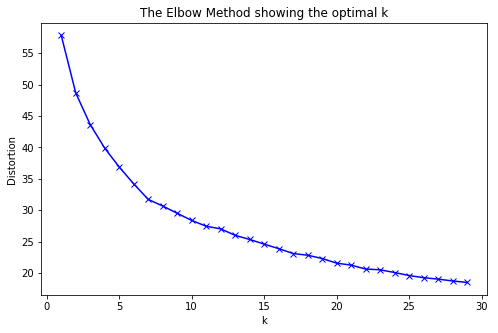

In [32]:
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<div class="alert alert-block alert-info">We'll set the number of clusters to 22 as sugegsted by the Elbow Method. This isn't too small and not too high so the clustering algorithm will find for us enough neighborhoods similar to the choosen 'reference'</div>

In [33]:
# set number of clusters
kclusters = 22

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 9,  9,  3,  1,  1,  3, 14,  7,  7, 11], dtype=int32)

<div class="alert alert-block alert-info">Let's define the function that returns num_top_venues the most common venues in the neighborhood</div>

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<div class="alert alert-block alert-info">Now we can create a new dataframe that would list all neighborhood and their most popular venues.</div>

In [35]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.rename(columns={'Neighborhood': 'Address'}, inplace=True)

<div class="alert alert-block alert-info">To be able to plot clustered neighborhood on the map we need to add the latitude and the longitude information back to the dataframe we are working with.</div>

In [75]:
london_merged = neighborhoods_venues_sorted.merge(df_london_locations, on='Address', how='inner')
print(london_merged.shape)
london_merged = london_merged.merge(df_areas_population_rltv_lon, left_on='Borough', right_on='LAD_NM', how='inner')
london_merged.drop(columns=['LAD_CD', 'LAD_NM', 'LONG', 'LAT', 'LAD_TYPE', 'All ages', 'AREALHECT'], inplace=True)
print(london_merged.shape)
london_merged.head()

(461, 11)
(461, 12)


Cluster Labels                                            Address  \
0               9  10, Stanhope Mews South, Brompton, Royal Borou...   
1               3  Gadsden House, Hazlewood Crescent, North Kensi...   
2               9  The Shed, 122, Palace Gardens Terrace, Royal B...   
3               9  11, Bransdale Close, Swiss Cottage, South Hamp...   
4              11  Athlone House Garden, Hampstead Lane, London B...   

  1st Most Common Venue 2nd Most Common Venue  3rd Most Common Venue  \
0            Restaurant                 Store          Entertainment   
1                 Store            Restaurant                   Café   
2            Restaurant                 Store                    Pub   
3            Restaurant                 Store                    Pub   
4                   Pub                  Café  Parks & Nature Object   

  4th Most Common Venue 5th Most Common Venue Postcode  \
0                 Hotel             Fast Food  SW7 5AW   
1             Fast Food                   Pub  W10 5DJ   
2                  Café             Fast Food   W8 4RT   
3                  Café             Fast Food  NW6 4QH   
4                 Store          Sports Venue   N6 4NT   

                  Borough   Latitude  Longitude     Density  
0  Kensington and Chelsea  51.493151  -0.180534  128.835019  
1  Kensington and Chelsea  51.524951  -0.207405  128.835019  
2  Kensington and Chelsea  51.509052  -0.193965  128.835019  
3                  Camden  51.540163  -0.192050  120.345120  
4                  Camden  51.570579  -0.161310  120.345120

<div class="alert alert-block alert-info">Now we can create a map which displays clustered neighborhoods.</div>

In [48]:
# create map
map_clusters = folium.Map(location=[london_center[1], london_center[0]], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

# add markers to the map
markers_colors = []
for lat, lon, post, brgh, cluster in zip(london_merged['Latitude'],london_merged['Longitude'],
                                         london_merged['Postcode'], london_merged['Borough'],
                                         london_merged['Cluster Labels']):
    label = folium.Popup(str(post) + ', ' + str(brgh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=1000,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.3).add_to(map_clusters)
    #folium.Circle([lat, lon], radius=700, popup=label, color='blue', fill=True, fill_color='blue', fill_opacity=0.1).add_to(map_london)
    
folium.Marker([my_center[1], my_center[0]]).add_to(map_clusters)
folium.Marker([london_center[1], london_center[0]]).add_to(map_clusters)
      
map_clusters

['#8000ff', '#6826fe', '#504afc', '#386df9', '#208ef4', '#08acee', '#12c8e6', '#2adddd', '#42edd3', '#5af8c8', '#72febb', '#8cfead', '#a4f89f', '#bced8f', '#d4dd80', '#ecc86f', '#ffac5c', '#ff8e4a', '#ff6d38', '#ff4a26', '#ff2613', '#ff0000']


### 'Candidate' Neighborhoods  <a name="candidates"></a>

<div class="alert alert-block alert-info">Now let's get all the neighborhood similar to the 'reference' and put them on the map.</div>

In [80]:
london_merged['Reference'] = (london_merged['Latitude'] - my_center[1])**2 + (london_merged['Longitude'] - my_center[0])**2
ref_cluster = london_merged.iloc[london_merged['Reference'].idxmin()]['Cluster Labels']
ref_density = london_merged.iloc[london_merged['Reference'].idxmin()]['Density']
i = 0
while not (threshold_scale[i] <= ref_density <= threshold_scale[i+1]):
    i += 1
print('Reference density range:' + str(threshold_scale[i]) + ',' + str(threshold_scale[i+1]))
    
similar_to_ref = london_merged[london_merged['Cluster Labels'] == ref_cluster]
similar_to_ref = similar_to_ref[(threshold_scale[i] <= similar_to_ref['Density']) & 
                                            (similar_to_ref['Density'] <= threshold_scale[i+1])]

Reference density range:72,108


In [81]:
# create map
map_clusters = folium.Map(location=[london_center[1], london_center[0]], zoom_start=10)
map_clusters.choropleth(
    geo_data=uk_geo, data=df_areas_population_rltv_lon, columns=['LAD_CD', 'Density'], key_on='feature.properties.LAD19CD',
    fill_color='YlOrRd', 
    fill_opacity=0.4, line_opacity=0.2, legend_name='London',
    threshold_scale=threshold_scale,
    reset=True
)

# add markers to the map
for lat, lon, post, brgh, cluster in zip(similar_to_ref['Latitude'],similar_to_ref['Longitude'],
                                         similar_to_ref['Postcode'],similar_to_ref['Borough'],
                                         similar_to_ref['Cluster Labels']):
    label = folium.Popup(str(post) + ', ' + str(brgh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=1000,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.4).add_to(map_clusters)
    
folium.Marker([my_center[1], my_center[0]]).add_to(map_clusters)
folium.Marker([london_center[1], london_center[0]]).add_to(map_clusters)
      
map_clusters

<div class="alert alert-block alert-info">Our clustering algorithm and popilation density analysis gave us 12 neighborhood that is very similar to the one that was choosen as a 'reference'. </div>

In [79]:
print(similar_to_ref.shape)
similar_to_ref[london_merged.columns[[1] + list(range(2, 9))]].head(60)

(12, 13)


Address 1st Most Common Venue  \
11   113, Pomeroy Street, Telegraph Hill, New Cross...                 Store   
12   Argosy House, Windlass Place, Hughesfield Esta...                 Store   
22   The Crescent, 2, Brookmill Road, Hughesfield E...            Restaurant   
102  North Woolwich Road, Silvertown, London Boroug...                 Hotel   
107  Victoria Walk, Stratford Marsh, London Borough...         Entertainment   
237  5, Oxford Road, Southfields, London Borough of...            Restaurant   
238  61,62,63, Nantes Close, Battersea, London Boro...                 Store   
240  Mills House, Thessaly Road, Patmore Estate, Ni...                 Store   
244  Trinity Road, Upper Tooting, London Borough of...                   Pub   
321  Hay Lane, Colindale, London Borough of Brent, ...                 Store   
453  Lordship Lane, Tottenham Hale, Tottenham, Lond...                 Store   
454  Woodland Rise, Shepherd's Hill, Muswell Hill, ...                 Store   

    2nd Most Common Venue  3rd Most Common Venue  4th Most Common Venue  \
11             Restaurant                    Pub  Parks & Nature Object   
12             Restaurant  Parks & Nature Object                    Pub   
22                  Store                    Pub                    Bar   
102             Transport             Restaurant                  Store   
107                 Store           Sports Venue                   Café   
237                 Store                    Pub                   Café   
238            Restaurant                    Pub                   Café   
240            Restaurant                    Pub                   Café   
244                 Store             Restaurant                   Café   
321            Restaurant  Parks & Nature Object              Fast Food   
453            Restaurant                    Pub              Transport   
454            Restaurant                   Café                    Pub   

     5th Most Common Venue  Postcode     Borough  
11               Fast Food  SE14 5FY    Lewisham  
12               Transport   SE8 3QZ    Lewisham  
22            Sports Venue   SE8 4HJ    Lewisham  
102              Fast Food   E16 2BB      Newham  
107             Restaurant   E20 2ST      Newham  
237              Fast Food  SW15 2LG  Wandsworth  
238              Fast Food  SW18 1JL  Wandsworth  
240  Parks & Nature Object       SW8  Wandsworth  
244           Sports Venue  SW18 3SH  Wandsworth  
321                    Pub   NW9 0NH       Brent  
453                    Bar   N17 8NS    Haringey  
454  Parks & Nature Object   N10 3UP    Haringey

## Results and Discussion <a name="results"></a>

To help John to find an ideal location for his new home we generated a list of the London areas which are very similar to the location he lives in right know and which he likes a lot.  
To achieve this:
* We obtained innformation on the coordinates of the London boroughs from the Open Geography Portal by the Office for National Statistics.
* We downloaded the information on the squares of these areas from the same wesite.
* Then we got estimates of the population for the UK, England and Wales, Scotland and Northern Ireland from the Office for National Statistics website. Extracted information on the London boroughs from this data set and then calculated the population density for each London borough.
* The results were displayed on the choropleth map using the Folium package.
* On the next step we generated the grid of areas with the 1000m radius covering the whole territory of London and obtained the information on the venues in each location using Foursquare API.
* We used K-means algorithm to cluster all the locations by teh number and categories of venues they got.
* The results were filtered to get all areas in the same cluster as teh 'reference' one and then using one more condition - the population density range - the same as for the 'reference' neighborhood.
* As the final step all 'candidate' neighborhoods were displayed on the map.

This project helped us to get the list of 12 'candidate' neighborhoods that John could consider as the new 'perfect' areas when looking for a new location of his new house.

## Conclusion  <a name="conclusion"></a>

Purpose of this project was to identify London areas similar to the neighborhood where John lives now to help him to find a new location for his new house.
To solve this problem we generate a grid of neighborhoods covering the whole territory of London.  
Using Foursquare API we obtain information on the venues in each neighborhood - their number and types.  
Then we clustered all areas with K-means algorithm to group similar ares into clusters.  
We came up with the list of **75 'candidate' neighborhoods which John could consider to move in**.

There are lots of different official open data sources available that could be used to narrow down the search even further and help John to make a better and more informed decision. This could be **the house prices, school ratings, hospital raitings, unemployment rate, crime rate, etc**.
The methodology used in this notebook could be refined further to incorporate the above listed data sources into the analysis and help to automate the decision making process.